## Notebooks to make the queries to the api of the models to get the response

In [1]:
import pandas as pd
import requests
from typing import Dict
import time
import os
import json
import re
import seaborn as sns
from matplotlib import pyplot as plt

### Reading the data

In [2]:
data = pd.read_csv("../02-dataset/data/cleaned/all_questions_df_english.csv")
data

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...
...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu..."
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...


## Making the requests

In [3]:
def get_text(line : pd.Series, lang: str, verbose = False):
    """
    """
    if lang == 'pt':
        prompt = \
        f"""Qual é a alternativa correta para a questão que está entre <>? responda só com a letra que representa a alternativa:\n\n<{line['text_concat_portuguese']}>"""
    else:
        prompt = \
        f"""What is the correct alternative to the question between <>? Answer only with the letter that represents the alternative:\n\n<{line['text_concat_english']}>"""

    if verbose:
        print(prompt)
    return prompt

def make_querie(url : str, text : str, temperature: float = None, stop_tokens: str = None):
    """
    """
    params = {}
    params['query'] = text
    if not(temperature is None):
        params['temperature'] = temperature
    if not(stop_tokens is None):
        params['stop_tokens'] = stop_tokens
    start_time = time.time()
    request = requests.get(url, params = params)

    return_infos = {
        'time_to_run': time.time() - start_time,
        'result': eval(request.text)['result']
    }
    
    return return_infos

def make_all_requests(
        df: pd.DataFrame, 
        models: Dict, 
        temperature: float,
        stop_tokens: str,
        path_to_save: str,
        lang: str,
        base_path: str = "http://localhost:8000",
        verbose: bool = True
    ):
    """
    """
    
    try:
        os.mkdir(path_to_save)
    except:
        pass

    for model,url in models.items():
        
        for index,line in df.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{model}.json"
            full_path_arq = f"{path_to_save}/{name_arq}"
            
            # if alredy process, not process
            if os.path.exists(full_path_arq):
                continue
            
            # otherwise compute
            url_req = base_path + url
            
            result = make_querie(
                url = url_req,
                text = get_text(line, lang),
                temperature = temperature,
                stop_tokens = stop_tokens
            )
            
            with open(full_path_arq, 'w') as file:
                file.write(json.dumps(result,indent=2,ensure_ascii=False))
            
            if verbose:
                print(f"--> {model} || {index} || {result}")

        print(f"Run the model {model}")
    

In [6]:
models = {
    "llama_7b":"/models/llama/7b",
    "llama_13b":"/models/llama/13b",
    "alpaca_7b": "/models/alpaca/7b",
    "alpaca_13b": "/models/alpaca/13b",
    "koala_7b": "/models/koala/7b",
    "koala_13b": "/models/koala/13b",
    "vicuna_7b": "/models/vicuna/7b",
    "vicuna_13b": "/models/vicuna/13b",
    "llama_2_7b": "/models/llama2/7b/",
    "llama_2_13b": "/models/llama2/13b/",
#     "vicuna1.5_7b": "/models/vicuna1.5/7b/",
#     "vicuna1.5_13b": "/models/vicuna1.5/13b/",
}

### First experiment. Only concatenating the text and seding to the model and collecting the response
- PT BR

In [7]:
PATH_SAVE_DATA = "data/03-prompt-ask"
LANG = 'pt'
BASE_PATH = "http://localhost:8000"

make_all_requests(
    df = data,
    models = models,
    temperature = 0.1,
    stop_tokens = "pergunta:,</s>,\n",
    path_to_save = PATH_SAVE_DATA,
    lang = LANG,
    base_path = BASE_PATH
)

Run the model llama_7b
Run the model llama_13b
Run the model alpaca_7b
Run the model alpaca_13b
Run the model koala_7b
Run the model koala_13b
Run the model vicuna_7b
Run the model vicuna_13b
Run the model llama_2_7b
Run the model llama_2_13b


### Reading the data processed

In [8]:
def get_response(
    path_jsons: str,
    dataframe: pd.DataFrame,
    models: Dict
):
    """
    """
    for name, _ in models.items():
        aux = []
        for index,line in dataframe.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{name}.json"
            
            with open(f"{path_jsons}/{name_arq}",'r') as file:
                json_response = json.loads(file.read())
            
            aux.append(json_response)
        dataframe[f'{name}_response'] = aux
            
    return dataframe

data_results = get_response(
    path_jsons = PATH_SAVE_DATA,
    dataframe = data.copy(),
    models = models
)

In [9]:
data_results

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,llama_13b_response,alpaca_7b_response,alpaca_13b_response,koala_7b_response,koala_13b_response,vicuna_7b_response,vicuna_13b_response,llama_2_7b_response,llama_2_13b_response
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 13.14290738105774, 'result': '...","{'time_to_run': 33.98447942733765, 'result': '...","{'time_to_run': 16.30357599258423, 'result': '...","{'time_to_run': 42.68650197982788, 'result': '...","{'time_to_run': 17.8051278591156, 'result': ' A'}","{'time_to_run': 40.500163316726685, 'result': ...","{'time_to_run': 17.710946083068848, 'result': ...","{'time_to_run': 56.73554348945618, 'result': '...","{'time_to_run': 24.52841019630432, 'result': '...","{'time_to_run': 31.31932497024536, 'result': '..."
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 26.112032175064087, 'result': ...","{'time_to_run': 52.95126223564148, 'result': '...","{'time_to_run': 28.713749885559082, 'result': ...","{'time_to_run': 62.31873631477356, 'result': '...","{'time_to_run': 30.987525701522827, 'result': ...","{'time_to_run': 61.87000751495361, 'result': '...","{'time_to_run': 32.18512749671936, 'result': '...","{'time_to_run': 91.36124157905579, 'result': '...","{'time_to_run': 48.58592104911804, 'result': '...","{'time_to_run': 51.95380258560181, 'result': '..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 18.950669527053833, 'result': ...","{'time_to_run': 37.33016395568848, 'result': '...","{'time_to_run': 23.90212321281433, 'result': '...","{'time_to_run': 51.950401306152344, 'result': ...","{'time_to_run': 22.4923198223114, 'result': ' A'}","{'time_to_run': 42.51880621910095, 'result': '...","{'time_to_run': 22.645551204681396, 'result': ...","{'time_to_run': 66.50597977638245, 'result': '...","{'time_to_run': 44.65715742111206, 'result': '...","{'time_to_run': 34.815072536468506, 'result': ..."
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 17.06998324394226, 'result': '...","{'time_to_run': 33.53783059120178, 'result': '...","{'time_to_run': 20.233322143554688, 'result': ...","{'time_to_run': 43.28195381164551, 'result': '...","{'time_to_run': 20.18866991996765, 'result': '...","{'time_to_run': 38.219605684280396, 'result': ...","{'time_to_run': 21.544825792312622, 'result': ...","{'time_to_run': 59.73345994949341, 'result': '...","{'time_to_run': 46.20769739151001, 'result': '...","{'time_to_run': 34.23786377906799, 'result': '..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 23.604277849197388, 'result': ...","{'time_to_run': 46.26517605781555, 'result': '...","{'time_to_run': 26.088366508483887, 'result': ...","{'time_to_run': 55.663700103759766, 'result': ...","{'time_to_run': 27.7711980342865, 'result': ' A'}","{'time_to_run': 52.65981197357178, 'result': '...","{'time

## Defining the heuristics to collect the response of the queries

In [10]:
def first_caracter(text: str):
    """
    """
    text = text.strip()
    if len(text) > 1 and text[0].isupper() and not(text[1].isalnum()) and text[0] in 'ABCDE':
        return text[0]
    if len(text) == 1 and text[0] in 'ABCDE':
        return text[0]

    return None

def identify_alternative_mid_text(text: str):
    """
    """
    regex1 = " <?[A-E]>? ?\)? "
    matches1 = re.findall(regex1,text)
    
    regex2 = " <?[A-E]>?\)?"
    matches2 = re.findall(regex2,text)
    
    matches = matches1 + matches2
    
    if len(matches) == 1:
        options = "ABCDE"
        for o in options:
            if o in matches[0]:
                return o
    return None


def run_identify_alternative_result(
    dataframe: pd.DataFrame
):
    """
    """
    heuristics = [
        first_caracter,
        identify_alternative_mid_text
    ]
    
    columns = [c for c in dataframe.columns if c.endswith("_response")]
    
    for column in columns:
        results = []
        for index,line in dataframe.iterrows():
            
            result = None
            for heuristic in heuristics:
                out = heuristic(line[column]['result'])
                if not(out is None):
                    result = out
                    break
            
            if not(result is None):
                results.append(result)
            else:
                results.append('-')
        dataframe[column.replace("_response","_prediction")] = results
    return dataframe
    
    

In [11]:
df_predictions = run_identify_alternative_result(data_results)
df_predictions

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,...,llama_7b_prediction,llama_13b_prediction,alpaca_7b_prediction,alpaca_13b_prediction,koala_7b_prediction,koala_13b_prediction,vicuna_7b_prediction,vicuna_13b_prediction,llama_2_7b_prediction,llama_2_13b_prediction
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 13.14290738105774, 'result': '...",...,D,A,A,A,A,A,D,B,B,C
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 26.112032175064087, 'result': ...",...,C,B,B,C,C,C,C,B,C,C
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 18.950669527053833, 'result': ...",...,A,A,A,A,A,A,E,B,D,B
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 17.06998324394226, 'result': '...",...,D,A,A,A,A,A,E,B,D,C
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 23.604277849197388, 'result': ...",...,D,A,A,D,A,A,D,B,D,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"{'time_to_run': 22.666972160339355, 'result': ...",...,E,D,A,D,A,A,D,B,D,A
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...,"{'time_to_run': 21.980838775634766, 'result': ...",...,B,-,B,A,A,A,B,B,D,A
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","{'time_to_run': 12.55783462524414, 'result': '...",...,D,B,B,B,C,B,D,B,D,C
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...,"{'time_to_run': 12.3869948387146, 'result': ' D'}",...,D,B,B,D,A,A,D,B,D,-


### How much of the all predictions where detected with the label

In [12]:
def compute_percentage_predictions(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    d = dataframe[columns]
    d = d == '-'
    a,b = d.shape
    d = d.sum().sum()
    
    return 1 - (d / (a*b))

c = compute_percentage_predictions(df_predictions)
print(f"Coverage predictions: {c}")

Coverage predictions: 0.9938369781312127


In [13]:
def verify_results_text(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    for column in columns:
        
        for index,line in dataframe.iterrows():
            
            if line[column] == '-':
                text = line[column.replace("_prediction","_response")]['result']
                print(f"--> {text}")
verify_results_text(df_predictions)

-->  2,06
-->  CLASTRES, P. A sociedade contra o Estado. O modelo político das sociedades discutidas no texto contrasta com o do Estado liberal burguês porque se baseia em:
--> 
-->  3
-->  1
--> 
--> 
-->  96) O que é o objetivo principal da pesquisa qualitativa?
--> 
--> 
--> 
--> 
--> 
-->  3
--> 
-->  10
-->  1
--> 
-->  12
--> 
-->  1
--> 
--> 
-->  22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> resposta: 22 março a de> res

## Computing the accuracy of the models

In [14]:
def accuracy(ground_truth, prediction):
    """
    """
    
    eq = ground_truth == prediction
    
    return eq.sum() / len(eq)

def compute_acc_by_year(
    df_predictions: pd.DataFrame
):
    """
    """
    years = list(set(df_predictions['year']))
    years.sort()
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for year in years:
            
            df_aux = df_predictions[df_predictions['year'] == year]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+years)
    
    

In [15]:
accuracy(df_predictions['ground_truth'],df_predictions['vicuna_13b_prediction'])

0.33697813121272363

## Accuracy by year

In [16]:
compute_acc_by_year(df_predictions)

,model,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2022
0,llama_7b,0.225806,0.22,0.212766,0.298507,0.242424,0.194690,0.191304,0.290909,0.254545,0.262626,0.098361
1,llama_13b,0.204301,0.27,0.180851,0.208955,0.171717,0.185841,0.252174,0.090909,0.227273,0.202020,0.245902
2,alpaca_7b,0.182796,0.24,0.180851,0.283582,0.212121,0.185841,0.139130,0.254545,0.200000,0.202020,0.229508
3,alpaca_13b,0.430108,0.38,0.425532,0.432836,0.434343,0.353982,0.382609,0.400000,0.345455,0.404040,0.475410
4,koala_7b,0.182796,0.27,0.127660,0.179104,0.171717,0.203540,0.173913,0.145455,0.163636,0.151515,0.262295
5,koala_13b,0.236559,0.31,0.212766,0.223881,0.242424,0.203540,0.217391,0.272727,0.236364,0.262626,0.295082
6,vicuna_7b,0.301075,0.33,0.329787,0.373134,0.353535,0.274336,0.356522,0.345455,0.336364,0.313131,0.295082
7,vicuna_13b,0.333333,0.30,0.308511,0.343284,0.373737,0.327434,0.313043,0.436364,0.363636,0.333333,0.311475
8,llama_2_7b,0.311828,0.26,0.319149,0.328358,0.272727,0.194690,0.295652,0.309091,0.309091,0.333333,0.327869
9,llama_2_13b,0.397849,0.47,0.478723,0.492537,0.393939,0.451327,0.417391,0.618182,0.463636,0.494949,0.606557


## Accuracy by knowlege area

In [17]:
def compute_acc_by_knowlege_area(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for sub in subjects:
            
            df_aux = df_predictions[df_predictions['subject'] == sub]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+subjects)

In [18]:
compute_acc_by_knowlege_area(df_predictions)

,model,Matemática e suas tecnologias,"Linguagens, códigos e suas tecnologias",Ciências da natureza e suas tecnologias,Ciências humanas e suas tecnologias
0,llama_7b,0.217949,0.233216,0.227074,0.221893
1,llama_13b,0.141026,0.250883,0.205240,0.204142
2,alpaca_7b,0.128205,0.208481,0.205240,0.233728
3,alpaca_13b,0.205128,0.441696,0.375546,0.473373
4,koala_7b,0.121795,0.212014,0.196507,0.180473
5,koala_13b,0.128205,0.303887,0.213974,0.266272
6,vicuna_7b,0.243590,0.356890,0.262009,0.384615
7,vicuna_13b,0.243590,0.353357,0.275109,0.408284
8,llama_2_7b,0.211538,0.339223,0.270742,0.304734
9,llama_2_13b,0.237179,0.462898,0.414847,0.615385


## Overall accuracy

In [19]:
def compute_acc_overall(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        list_output.append(accuracy(df_predictions['ground_truth'],df_predictions[column]))
            
    return pd.DataFrame([list_output],columns=[c.replace("_prediction","") for c in columns ])
    
    

In [20]:
compute_acc_overall(df_predictions)

,llama_7b,llama_13b,alpaca_7b,alpaca_13b,koala_7b,koala_13b,vicuna_7b,vicuna_13b,llama_2_7b,llama_2_13b
0,0.225646,0.207753,0.203777,0.400596,0.183897,0.243539,0.327038,0.336978,0.292247,0.468191


## Compute mean time predictions
- this notebook run on a ryzen 5 3600x

In [21]:
def compute_mean_times(df: pd.DataFrame):
    """
    """
    columns = [c for c in df.columns if c.endswith('_response')]
    
    mean_runs = {}
    
    for c in columns:
        
        tempos = list(df[c].apply(lambda x: x['time_to_run']))
        
        model = c.replace("_response","")
        
        mean_runs[model] = sum(tempos) / len(tempos)
        
    return mean_runs

In [22]:
compute_mean_times(data_results)

{'llama_7b': 18.395392145124628,
 'llama_13b': 35.58258009193906,
 'alpaca_7b': 20.534261223099104,
 'alpaca_13b': 45.31694722578492,
 'koala_7b': 21.4601046896834,
 'koala_13b': 41.23235608047804,
 'vicuna_7b': 21.767693233774388,
 'vicuna_13b': 64.27952563478269,
 'llama_2_7b': 17.558762156702652,
 'llama_2_13b': 34.3166134454621}

## Verifying the distribuition over the question in all the models

In [23]:
def compute_distribuition_answers(df: pd.DataFrame):
    """
    """
    
    alternatives = "ABCDE"
    columns = [c for c in df.columns if c.endswith('_prediction')]
    
    counts = []
    for column in columns:
        for alternative in alternatives:
            
            model = column.replace("_prediction","")
            
            alter_percen = sum(df[column] == alternative) / sum(df[column] != '-')
            
            counts.append([model,alter_percen,alternative])
            
    return pd.DataFrame(counts,columns = ['model','percent', 'alternative'])
            
    

In [24]:
percents = compute_distribuition_answers(data_results)

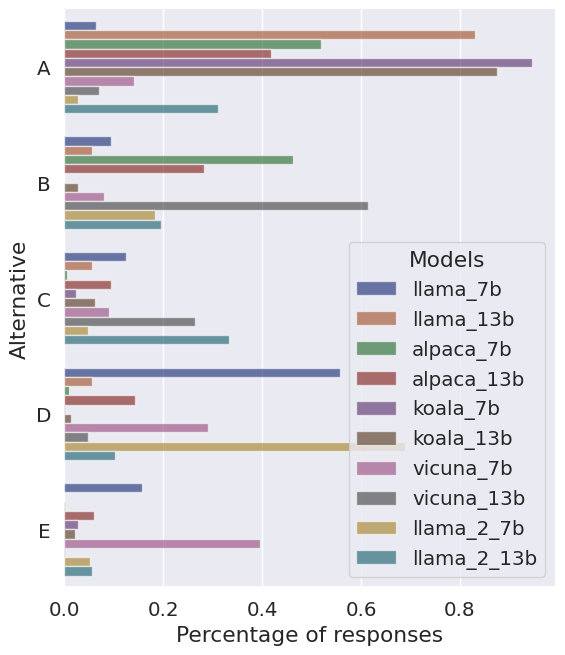

In [25]:
sns.set_theme()
sns.set(font_scale=1.3)
g = sns.catplot(data = percents, kind = "bar", y = "alternative", x = 'percent', hue = 'model',
    errorbar="sd", palette="dark", alpha=.6, height=6)
g.despine(left=True)
g.set_axis_labels("Percentage of responses","Alternative")
g.legend.set_title("")
g.fig.set_figwidth(8)
g.fig.set_figheight(7)
g._legend.remove()
plt.legend(loc='lower right',title="Models")
plt.savefig("plots/distribution-alternatives-portuguese.svg",format="svg")